# Dew Point and Pitching 

I have been tasked to identify the probability a pitch in the dataset was affected by a dew point 
greater than 65 degrees F

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

## Import Data

In [2]:
df = pd.read_csv('data.csv')
pid_list = df.PID

# Order Pitchers with Pitch Count is ascending order
df = df.loc[(df.groupby('PITCHER_KEY')['PITCHER_KEY'].transform('count').sort_values()).index].reset_index()

In [3]:

# df = df.loc[(df.groupby('PITCHER_KEY')['PITCHER_KEY'].transform('count').sort_values())].reset_index()

In [4]:
# Check to see what pitches we are dealing with
print('Pitch Types:',df.PITCH_TYPE_TRACKED_KEY.unique())

# Check to see how many different pitchers we are working with
print('Pitchers:',len(df.PITCHER_KEY.unique()))

Pitch Types: ['FB' 'KN' 'SL' 'CH' 'SI' 'CF' 'CB' 'SF' 'SW' 'UN']
Pitchers: 37


We are working with 10 different pitch types and 37 different pitchers.

# Select Features

In [5]:
feature_list = ['HORIZONTAL_BREAK','INDUCED_VERTICAL_BREAK', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE']

# Train Model

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# To determine if a pitch is an outlier, we are using an Isolation Forrest model
# to detect anomalies in the data set. We are assuming that any abnormal pitches
# from the selected features is an outlier.

# To simplify the training, we will get the difference to the pitcher's mean features. 
X = df[feature_list] - df[feature_list+['PITCHER_KEY','PITCH_TYPE_TRACKED_KEY']].groupby(['PITCHER_KEY','PITCH_TYPE_TRACKED_KEY']).transform('mean')

# Create and fit an Isolation Forest model
isof = IsolationForest(contamination=0.1, random_state=0)
isof.fit(X.values)

# Calculate Anomaly Scores
anomaly_scores = isof.decision_function(X.values)
min_score = min(anomaly_scores)
max_score = max(anomaly_scores)

# Predict outliers (1 for inliers, -1 for outliers)
y_pred = isof.predict(X.values)

# Using anomaly scores, we can predict the probability that a pitch is an outlier
outlier_probabilities = (-anomaly_scores + max_score) / (max_score - min_score)

# Get metrics for the probabilities
df_prob = pd.DataFrame(data={'predict':outlier_probabilities},index=X.index)
df['prob'] = df_prob['predict']
df_prob.describe()



,predict
count,9889.000000
mean,0.198069
std,0.145630
min,0.000000
25%,0.088149
50%,0.158623
75%,0.273414
max,1.000000


# Plots

## Histogram of Probabilities

(0.0, 1.0)

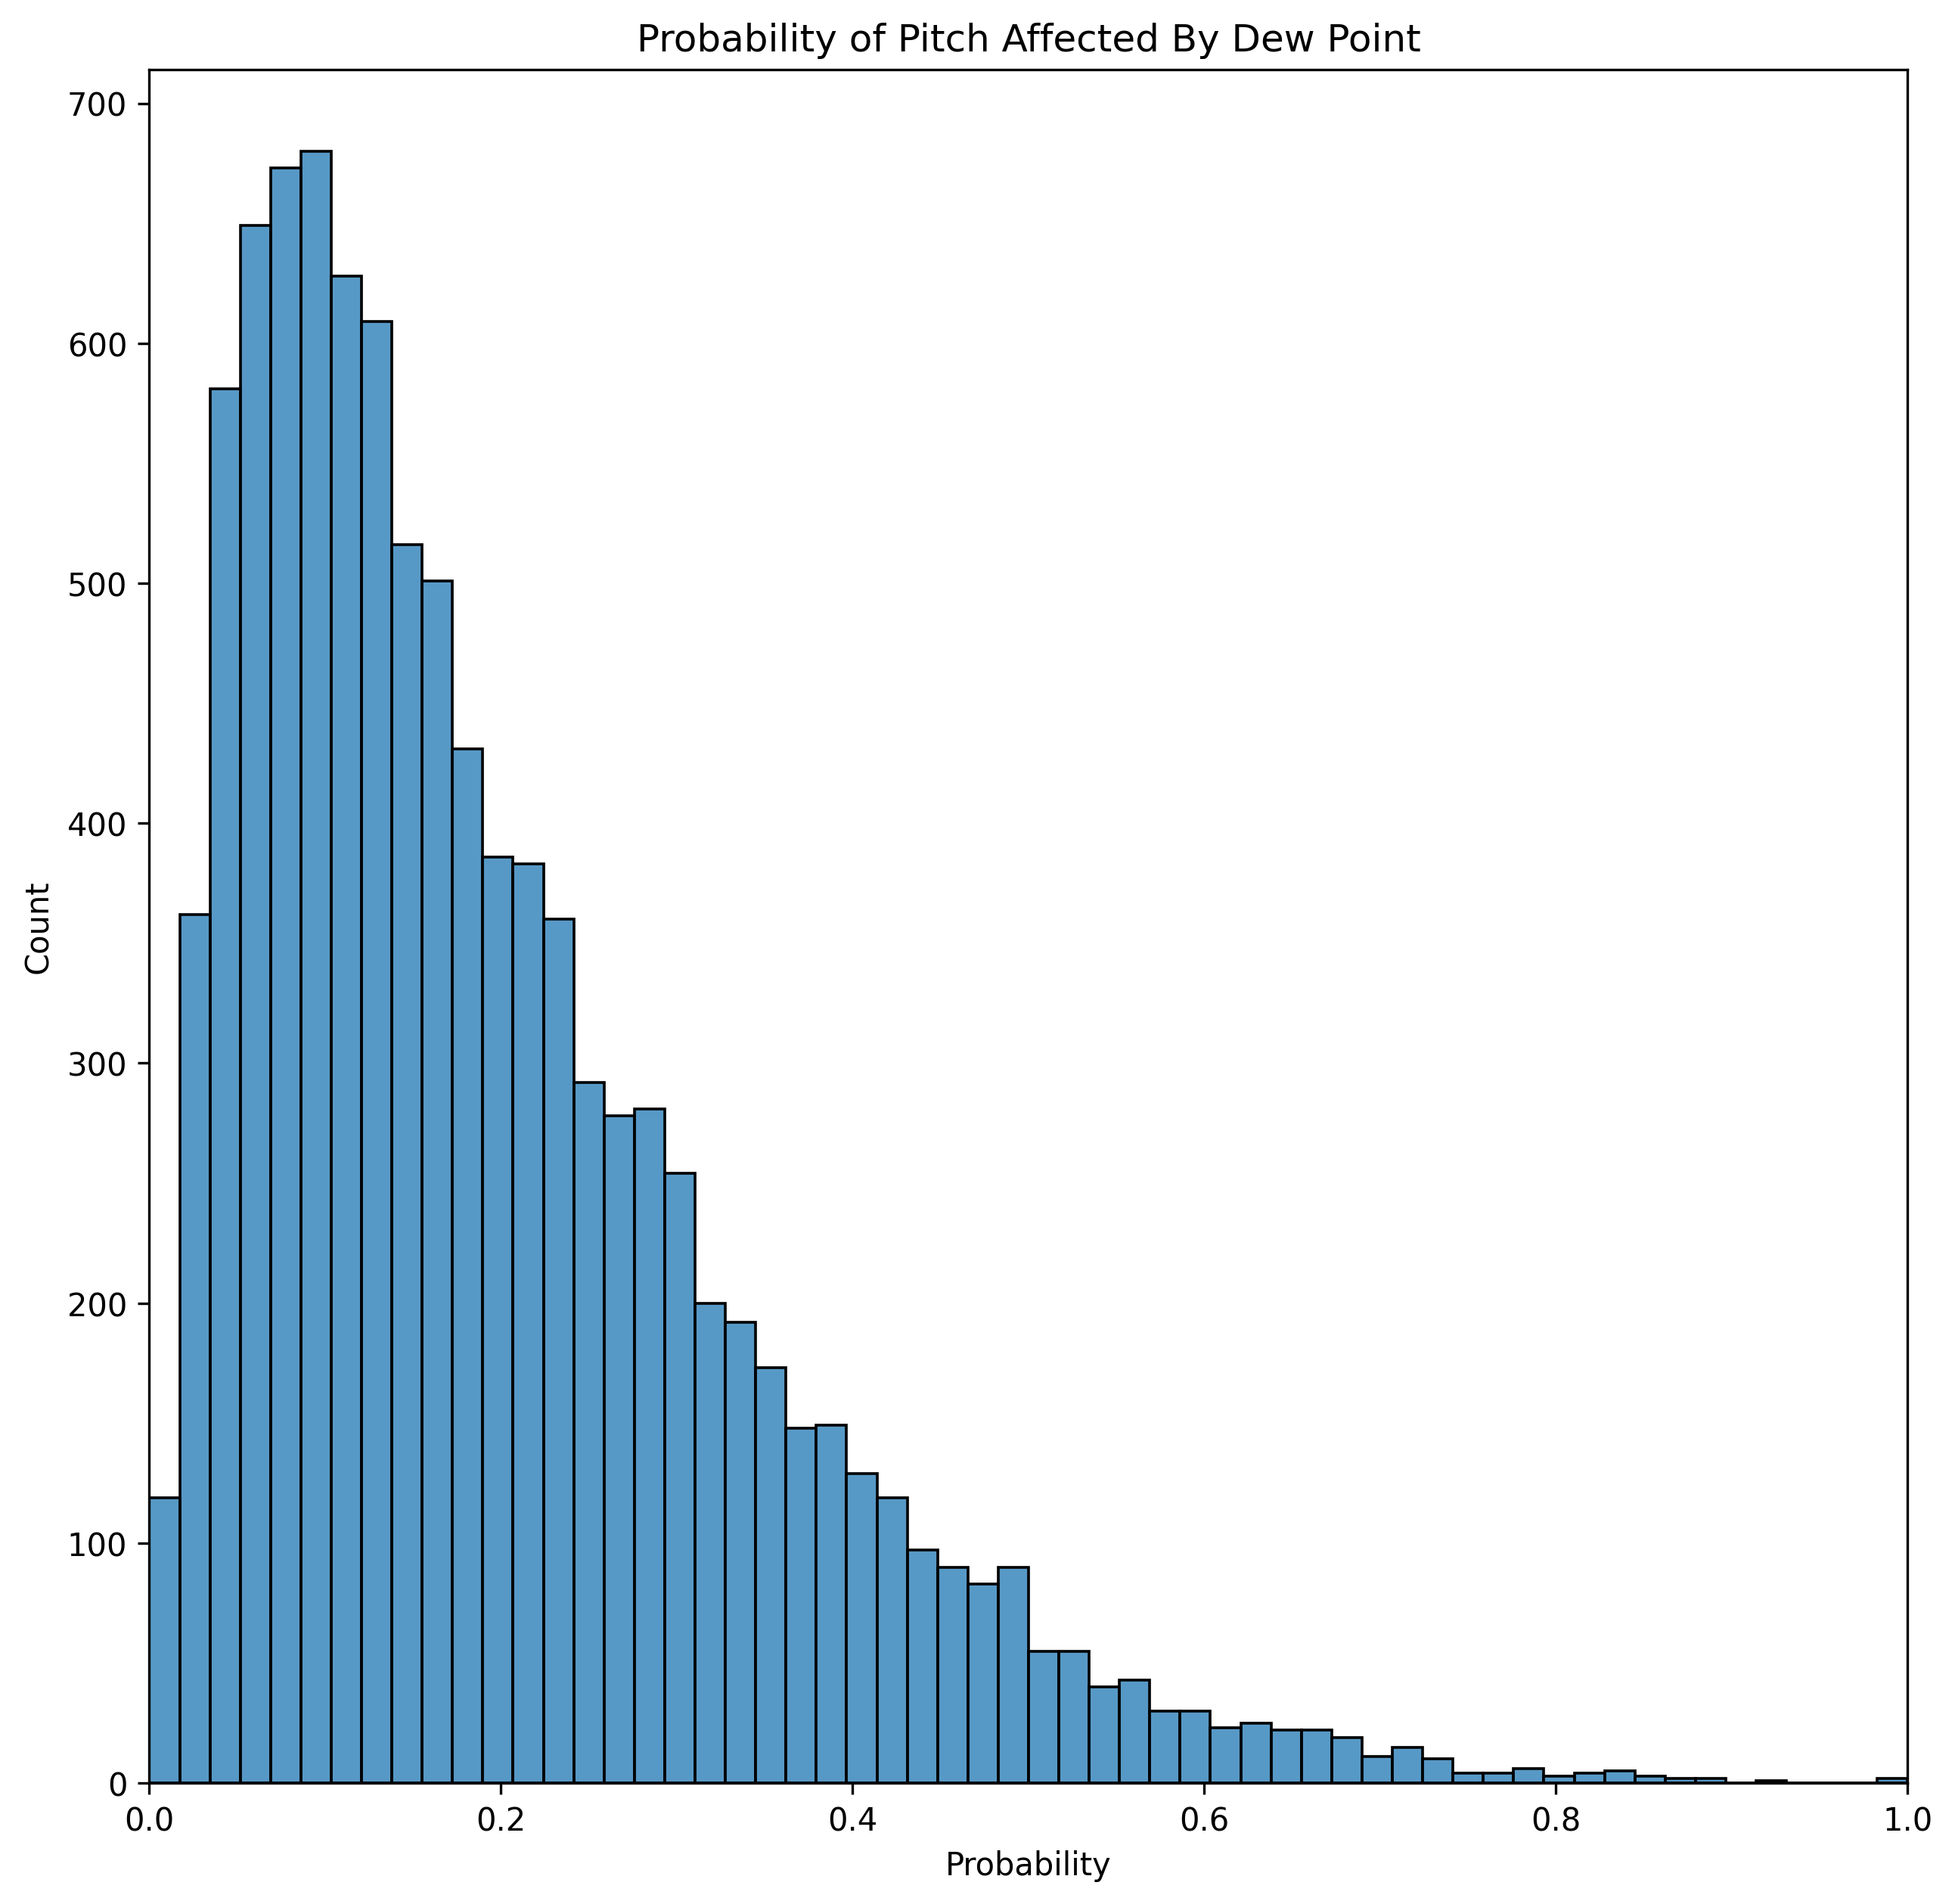

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),dpi=300)
sns.histplot(df_prob,ax=ax)
ax.get_legend().remove()
ax.set_title('Probability of Pitch Affected By Dew Point')
ax.set_xlabel('Probability')
ax.set_xlim(0,1)

## Scatter Plot of HB vs iVB and Probability

<ipython-input-8-bc8dc761d75d>:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(sm, ax=ax,orientation='vertical',aspect=15,shrink=0.7,label='Probability')


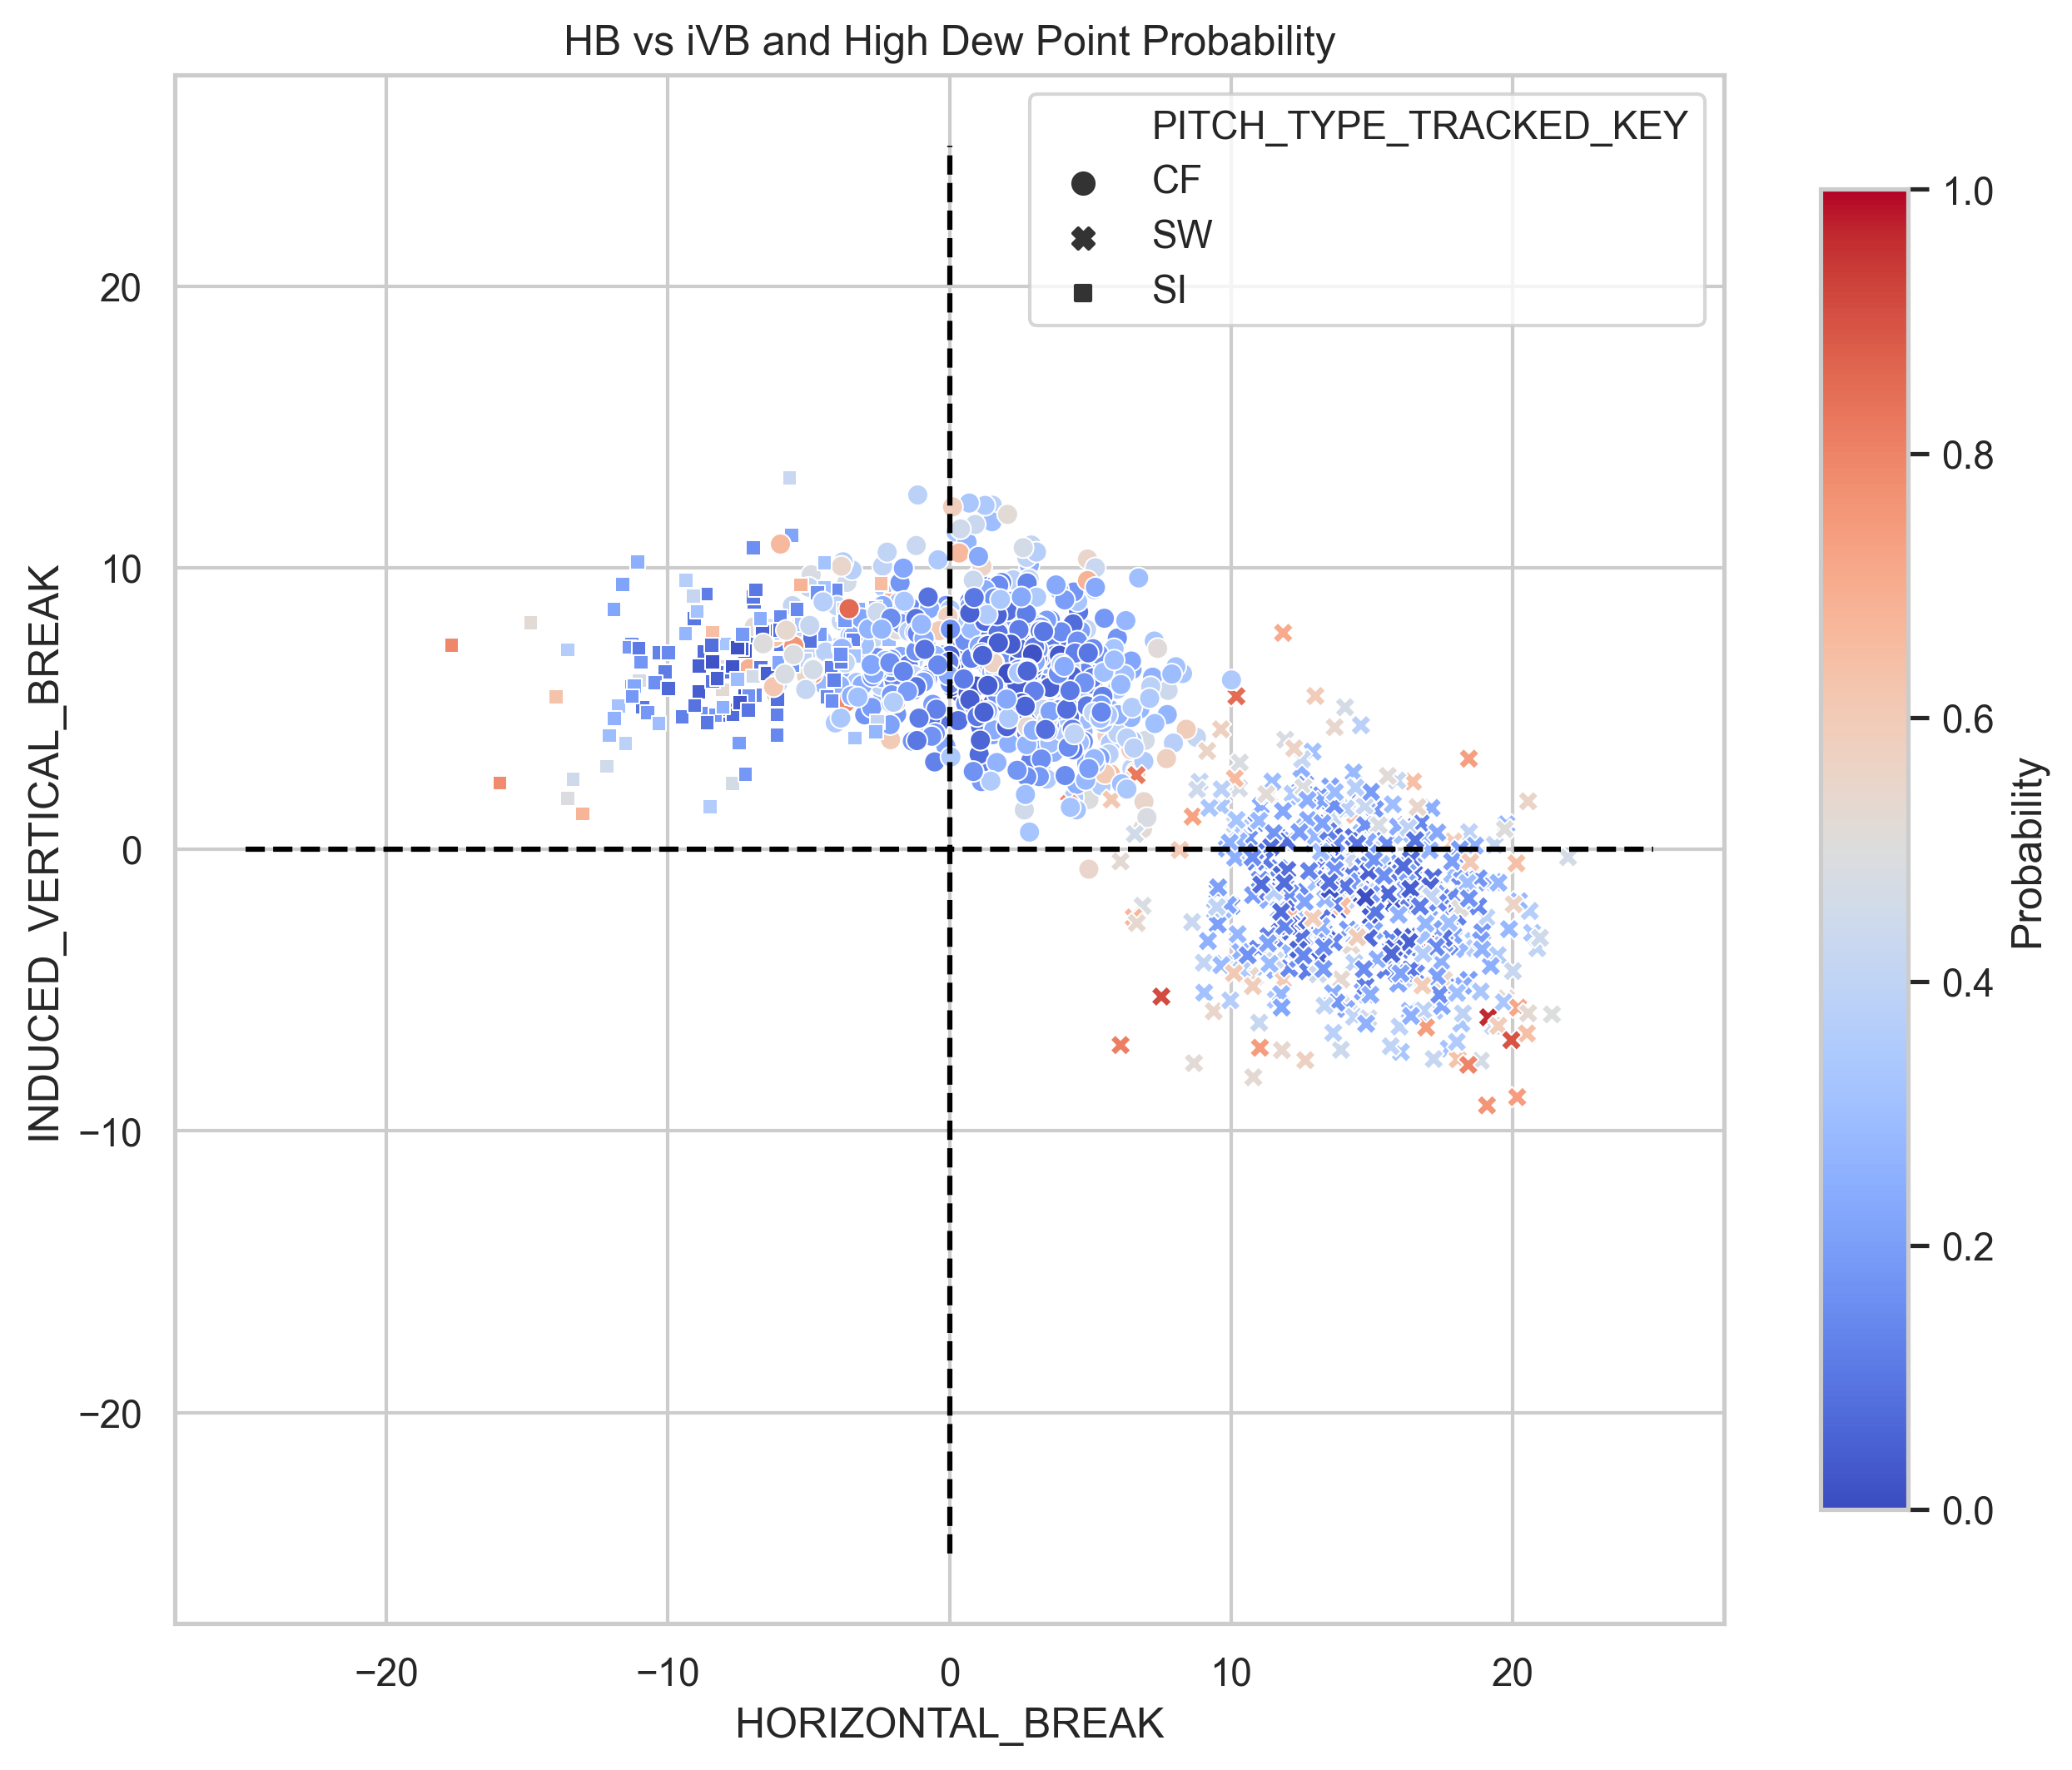

In [8]:
X['predict']  = pd.DataFrame(data={'predict':outlier_probabilities},index=X.index).values

sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),dpi=300)
sns.scatterplot(data=df[df.PITCHER_KEY==df.PITCHER_KEY.unique()[-1]],x=feature_list[0], y=feature_list[1], style='PITCH_TYPE_TRACKED_KEY',hue='prob',palette='coolwarm')
ax.set_title('HB vs iVB and High Dew Point Probability')

ax.set_ylim(-25,25)
ax.set_xlim(-25,25)

ax.vlines(x=0,ymin=-25,ymax=25,color='black',linestyles='--')
ax.hlines(y=0,xmin=-25,xmax=25,color='black',linestyles='--')
norm = plt.Normalize(0,1)

sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
ax.figure.colorbar(sm, ax=ax,orientation='vertical',aspect=15,shrink=0.7,label='Probability')

# Create a legend without hues
handles, labels = plt.gca().get_legend_handles_labels()
legend_labels = labels[labels.index('PITCH_TYPE_TRACKED_KEY'):]
handles_label = handles[labels.index('PITCH_TYPE_TRACKED_KEY'):]
# Create a legend with markers only (no hues)
plt.legend(handles=handles_label, labels=legend_labels, loc='best', markerscale=1)

ax.set_xlabel(f'{feature_list[0]}')
ax.set_ylabel(f'{feature_list[1]}')
ax.axis('square')
fig.set_facecolor('white')
plt.show()

# Export Results

In [9]:
df[['PID','prob']].rename(columns={'prob':'DEWPOINT_AFFECTED'}).to_csv('submission.csv',index=False)